# Trabajo Práctico Final: Traxbot (Localización y Movimiento)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Parte 2. Localización con ruido

In [3]:
sys.path.append("part_2")
!tree part_2

part_2
├── matrix.py
├── parte_2.py
├── __pycache__
│   ├── matrix.cpython-37.pyc
│   ├── parte_2.cpython-37.pyc
│   ├── robot.cpython-37.pyc
│   └── robot.cpython-38.pyc
└── robot.py

1 directory, 7 files


In [4]:
# demo_grading() es la función de evaluación del resultado
# naive_next_pos() es la estrategia de localización
from parte_2 import demo_grading, naive_next_pos, distance_between

In [5]:
from robot import robot, angle_trunc

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_history(history,error_threeshold = 0.1):
    """ Muestra el histórico de posición. Cada entrada es una tupla (x_real,y_real,x_est,y_est,error)
    """
    fig,axes = plt.subplots(4,1,figsize=(22,20))
    
    x_real = history[:,0]
    y_real = history[:,1]
    x_pred = history[:,2]
    y_pred = history[:,3]

    # XY
    axes[0].scatter(history[:,0],history[:,1],color="b");
    axes[0].scatter(history[:,2],history[:,3],color="r");
    axes[0].grid(which="both")
    axes[0].axis('square')
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].set_title("XY")
    axes[0].legend(["Posición real","Estimación"]);

    axes[1].plot(np.arange(0,len(history)),history[:,2],color="r")
    axes[1].scatter(np.arange(0,len(history)),history[:,0],color="b")
    axes[1].grid(which="both")
    axes[1].set_xlabel("tiempo")
    axes[1].set_ylabel("x")
    axes[1].set_title("x y \hat{x}")
    axes[1].legend(["Estimación","Posición real"]);

    axes[2].plot(np.arange(0,len(history)),history[:,3],color="r")
    axes[2].scatter(np.arange(0,len(history)),history[:,1],color="b")
    axes[2].grid(which="both")
    axes[2].set_xlabel("tiempo")
    axes[2].set_ylabel("y")
    axes[2].set_title("y y \hat{y}")
    axes[2].legend(["Estimación","Posición real"]);
        
    mse = np.sqrt((x_real-x_pred)**2 + (y_real-y_pred)**2)
    axes[3].plot(np.arange(0,len(history)),mse,color="b")
    axes[3].grid(which="both")
    axes[3].set_xlabel("tiempo")
    axes[3].set_ylabel("MSE")
    axes[3].set_title("MSE")    
    axes[3].axhline(error_threeshold)
    axes[3].legend(["MSE","Umbral de error"])
    
    fig.tight_layout()

In [7]:
help(robot.__init__)

Help on function __init__ in module robot:

__init__(self, x=0.0, y=0.0, heading=0.0, turning=0.6283185307179586, distance=1.0)
    This function is called when you create a new robot. It sets some of
    the attributes of the robot, either to their default values or to the values
    specified when it is created.



In [8]:
help(robot.set_noise)

Help on function set_noise in module robot:

set_noise(self, new_t_noise, new_d_noise, new_m_noise)
    This lets us change the noise parameters, which can be very
    helpful when using particle filters.



In [9]:
def testcase(estimator):
    x = 2.1
    y = 4.3
    heading = 0.5
    turning = 2.0*np.pi / 34.0
    distance = 1.5

    estimator = naive_next_pos
    test_target = robot(x, y, heading, turning, distance)

    new_t_noise = 0.0
    new_d_noise = 0.0

    # Ruido de medición
    new_m_noise = 0.05 * test_target.distance
    test_target.set_noise(new_t_noise, new_d_noise, new_m_noise)    
    localized, history = demo_grading(estimator, test_target)
    plot_history(history)

### Estrategia de localización "boba"

Sorry, it took you too many steps to localize the target.


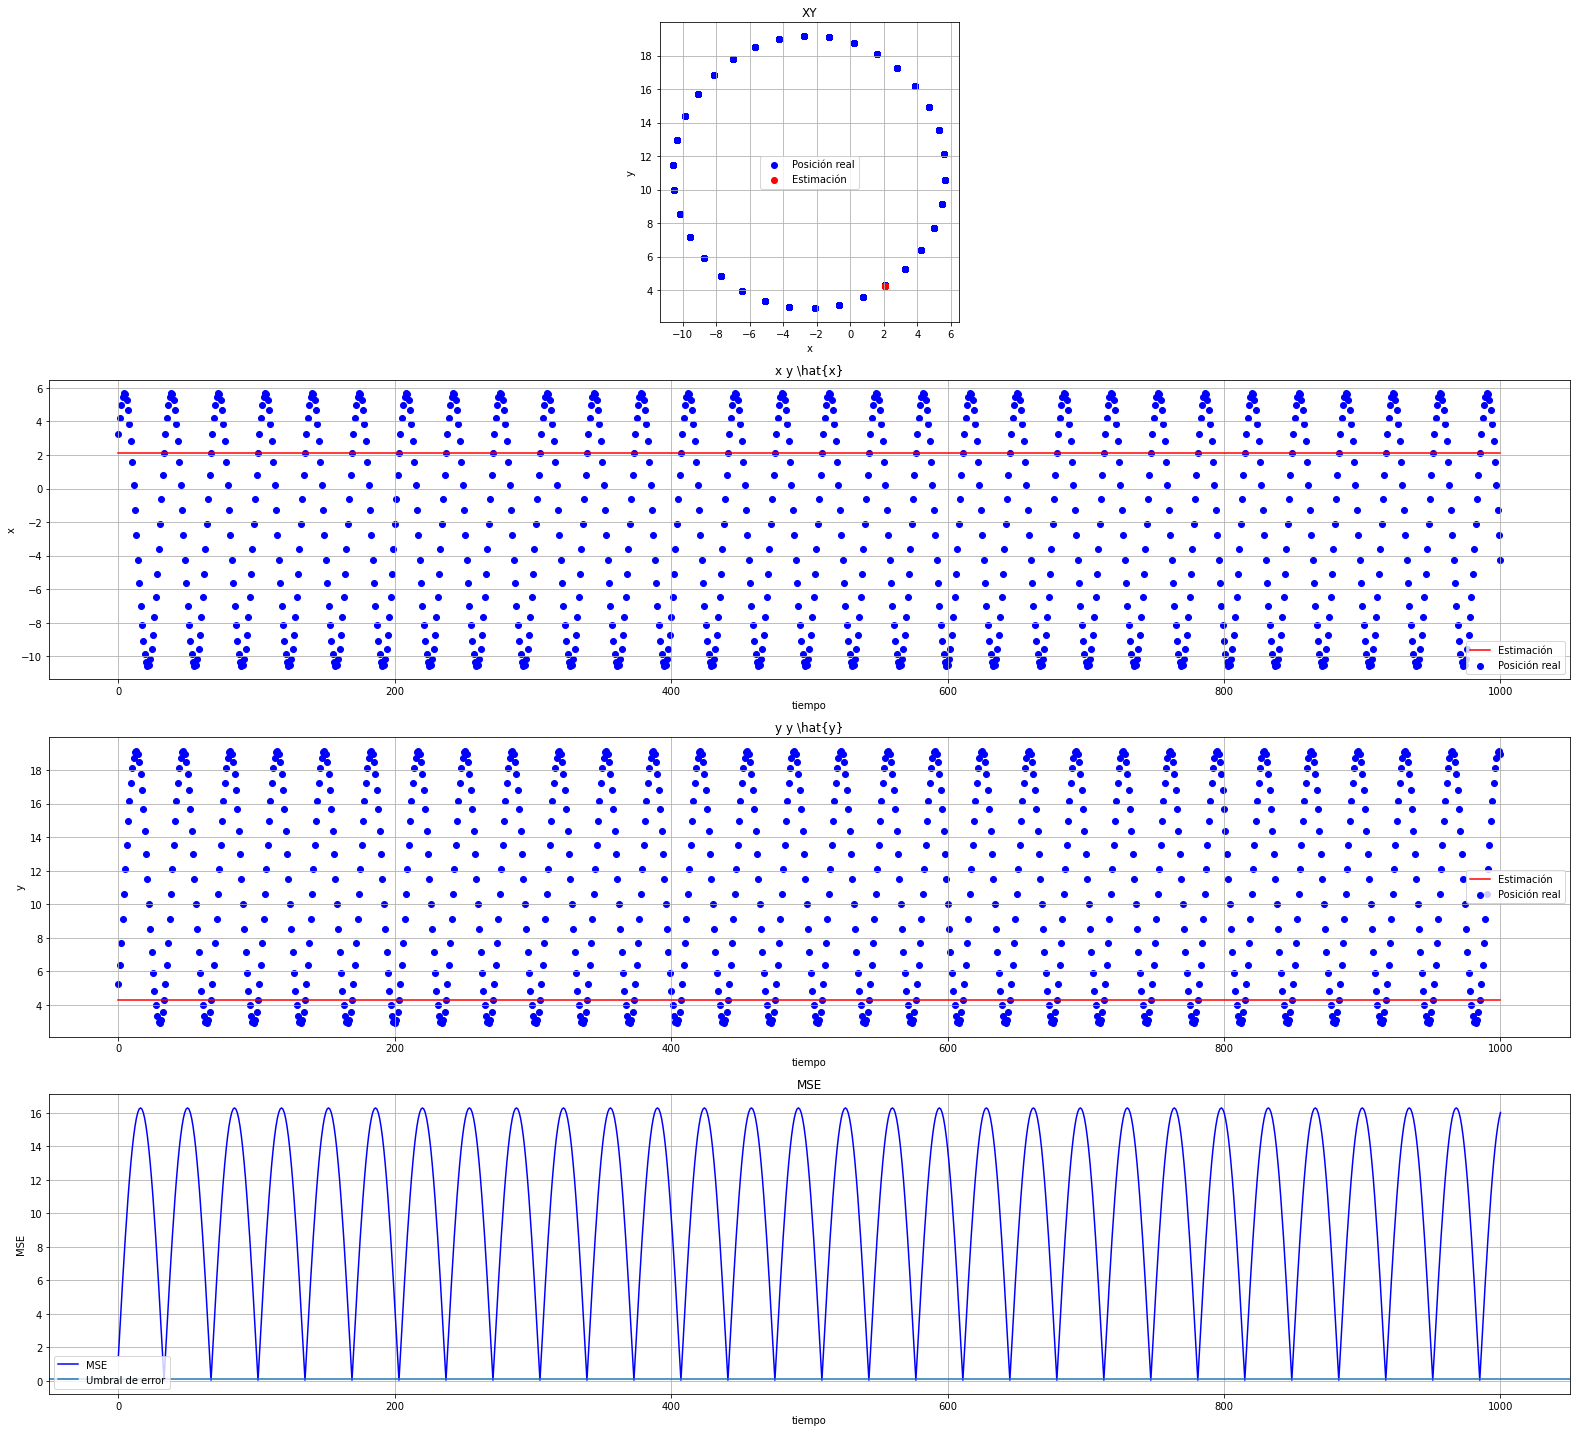

In [10]:
testcase(naive_next_pos)

### Estrategia de localización con estimación con filtro de Kalman extendido

#### Modelo cinemático

El estado del robot puede representarse como un vector:

$$
X = 
\begin{bmatrix}
x        \\
y        \\
dist     \\
\theta   \\
d\theta  \\
\end{bmatrix}
$$

donde:

- $x$ es la posición en X.
- $y$ es la posición en Y.
- $dist$ es el desplazamiento en cada iteración.
- $\theta$ es el ángulo de la orientación actual.
- $d\theta$ es el la velocidad de giro.

Modelo cinemático y matriz de transición

In [11]:
import sympy as sp

x = sp.Symbol(r"x")
y = sp.Symbol(r"y")
dist = sp.Symbol(r"dist")
theta = sp.Symbol("\\theta")
dtheta = sp.Symbol("d\\theta")
dt = sp.Symbol("dt")

Matriz de estado

In [12]:
X = sp.Matrix([x,y,dist,theta,dtheta])
X

Matrix([
[      x],
[      y],
[   dist],
[ \theta],
[d\theta]])

Ecuaciones de estado.

In [13]:
x_new = x + dist*sp.cos(theta+dtheta)
y_new = y + dist*sp.sin(theta+dtheta)
dist_new = dist
theta_new = theta + dtheta*dt
dtheta_new = dtheta

X_new = sp.Matrix([x_new,y_new,dist_new,theta_new,dtheta_new])
X_new

Matrix([
[dist*cos(\theta + d\theta) + x],
[dist*sin(\theta + d\theta) + y],
[                          dist],
[           \theta + d\theta*dt],
[                       d\theta]])

Matriz de transición de estado.

In [14]:
A = sp.Matrix([x_new,y_new,dist_new,theta_new,dtheta_new])
A

Matrix([
[dist*cos(\theta + d\theta) + x],
[dist*sin(\theta + d\theta) + y],
[                          dist],
[           \theta + d\theta*dt],
[                       d\theta]])

Por tratarse de un problema continuo no lineal con distribución unimodal, no son aplicables:
    
- Filtro de histograma (discreto).
- Filtro de Kalman lineal.

El problema puede resolverse con:

- Filtro de Kalman no lineal, por ejemplo extendido.
- Filtro de partículas

Se elige la primera opción.

#### Diseño de un filtro de Kalman extendido

Estado / estado inicial.

In [15]:
X = np.array([[0.], [0.], [0.], [0.], [0.]])
X.shape

(5, 1)

Matriz de covarianza.

In [16]:
P = np.diag([1000.0]*5)
P

array([[1000.,    0.,    0.,    0.,    0.],
       [   0., 1000.,    0.,    0.,    0.],
       [   0.,    0., 1000.,    0.,    0.],
       [   0.,    0.,    0., 1000.,    0.],
       [   0.,    0.,    0.,    0., 1000.]])

Medición.

In [17]:
H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0, 0.0]])
H

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Ruido de medición.

In [18]:
measurement_noise = 0.1
R = np.array([[measurement_noise, 0],
             [0, measurement_noise]])
R

array([[0.1, 0. ],
       [0. , 0.1]])

In [19]:
class ExtendedKalmanFilter:
    """ Filtro de Kalman extendido
    """
    def __init__(self,X,P,H,R,compute_state_transition_jacobian_fn,dt=1):
        """ Constructor por defecto
        """
        self.X = X
        self.P = P
        self.H = H
        self.R = R
        self.dt = dt
        self.compute_state_transition_jacobian = compute_state_transition_jacobian_fn
        
        self.n_states = self.X.shape[0]
        self.n_measurements = self.R.shape[0]
        
        self.I = np.eye(self.n_states)
                
        assert(self.X.shape==(self.n_states,1))
        assert(self.P.shape==(self.n_states,self.n_states))
        assert(self.H.shape==(self.n_measurements,self.n_states))
        assert(self.R.shape==(self.n_measurements,self.n_measurements))
        assert(self.I.shape==(self.n_states,self.n_states))
    
    def update_and_predict(self,z, OTHER = None):
        """ Actualizar medición y predecir nuevo estado
        """
        Z = np.array([[z[0],z[1]]])
        assert(Z.shape==(1,self.n_measurements))
        
        y = Z.T - (self.H @ self.X)
        assert(y.shape==(self.n_measurements,1))
        
        S = self.H @ self.P @ self.H.T + self.R
        assert(S.shape==(self.n_measurements,self.n_measurements))        
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        self.X = self.X + (K@y)
        assert(self.X.shape==(self.n_states,1))
        
        self.P = (self.I - (K@self.H)) @ self.P
        assert(self.P.shape==(self.n_states,self.n_states))        
        
        x = self.X[0][0]
        y = self.X[1][0]
        dist = self.X[2][0]
        theta = self.X[3][0]
        dtheta = self.X[4][0]
        
        self.X = np.array([
            [ x + dist*np.cos(theta+dtheta)],
            [ y + dist*np.sin(theta+dtheta)],
            [dist],
            [theta+dtheta],
            [dtheta]      
        ])
        assert(self.X.shape==(self.n_states,1))
    
        A = self.compute_state_transition_jacobian(self.X,self.dt)
        assert(A.shape==(self.n_states,self.n_states))
        
        self.P = A @ self.P @ A.T
        assert(self.X.shape==(self.n_states,1))
        
        xy_estimate = [self.X[0][0],self.X[1][0]]
        return xy_estimate, OTHER

Jacobiano de matriz de transición de estado:

In [20]:
A.jacobian([x,y,dist,theta,dtheta]) 

Matrix([
[1, 0, cos(\theta + d\theta), -dist*sin(\theta + d\theta), -dist*sin(\theta + d\theta)],
[0, 1, sin(\theta + d\theta),  dist*cos(\theta + d\theta),  dist*cos(\theta + d\theta)],
[0, 0,                     1,                           0,                           0],
[0, 0,                     0,                           1,                          dt],
[0, 0,                     0,                           0,                           1]])

Para no hacer dependiente el filtro Kalman extendido del jacobiano, se implementa como un callback.

In [21]:
def compute_state_transition_jacobian(X,dt):
    x = X[0][0]
    y = X[1][0]
    dist = X[2][0]
    theta = X[3][0]
    dtheta = X[4][0]
    A = np.array([
        [1.0,  0.0 ,  np.cos(theta+dtheta), -dist*np.sin(theta+dtheta), -dist*np.sin(theta+dtheta) ],
        [0.0,  1.0 ,  np.sin(theta+dtheta),  dist*np.cos(theta+dtheta),  dist*np.cos(theta+dtheta) ],
        [0. ,  0.  ,  1.0                 ,  0.                       , 0.                         ],
        [0. ,  0.  ,  0.                  ,  1.                       , dt                         ],
        [0. ,  0.  ,  0.                  ,  0.                       , 1.0                        ]
    ])
    return A

#### Caso de prueba

You got it right! It took you  182  steps to localize.


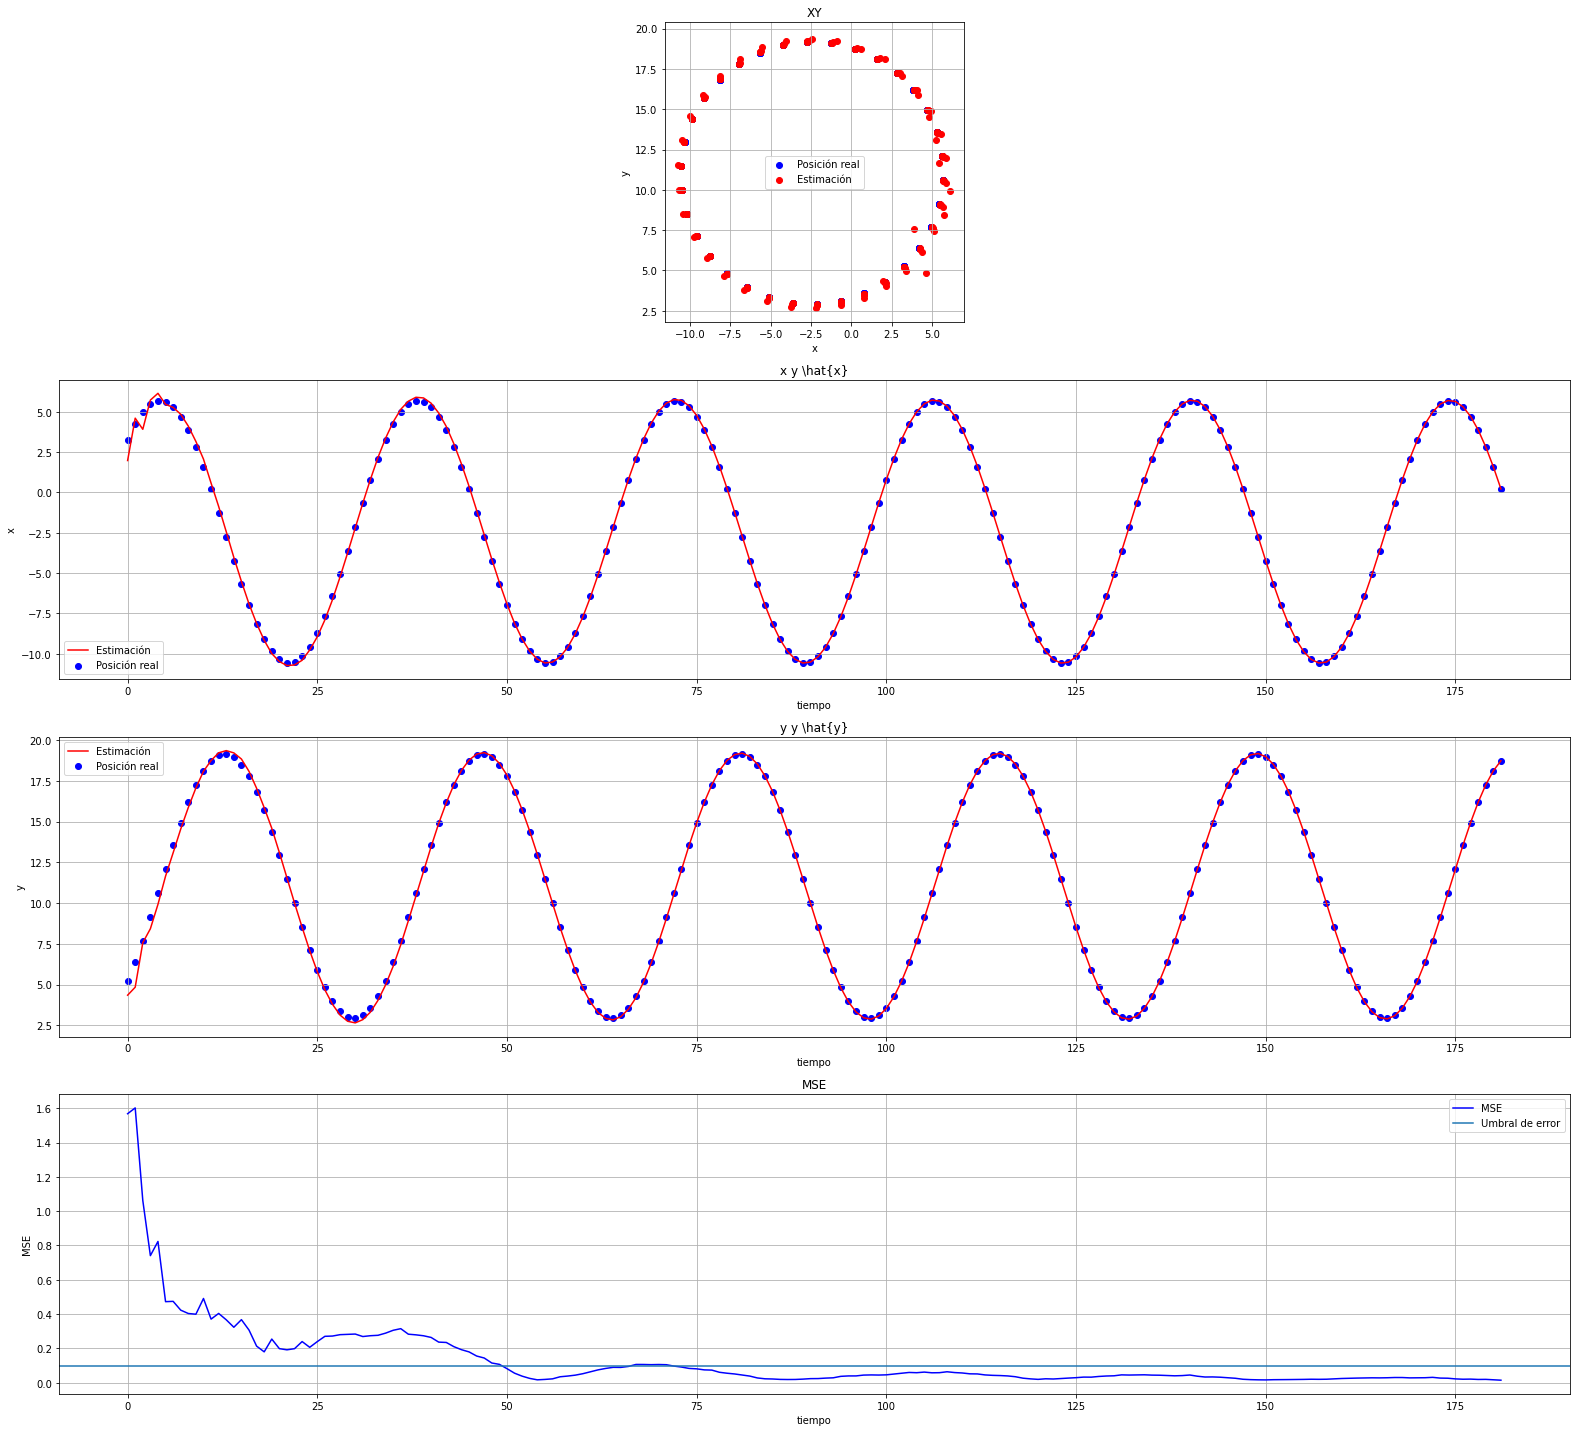

In [22]:
x = 2.1
y = 4.3
heading = 0.5
turning = 2.0*np.pi / 34.0
distance = 1.5

estimator = naive_next_pos
test_target = robot(x, y, heading, turning, distance)

new_t_noise = 0.0
new_d_noise = 0.0

# Ruido de medición
new_m_noise = 0.05 * test_target.distance
test_target.set_noise(new_t_noise, new_d_noise, new_m_noise)   

# Construir matrices

# Estado inicial
X = np.array([[0.], [0.], [0.], [0.], [0.]])

# Matriz de covarianza
P = np.diag([1000.0]*5)

# Matriz de variables observables (medición)
H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0, 0.0]])

# Matriz de ruido de medición
R = np.array([[new_m_noise, 0],
             [0, new_m_noise]])


ekf = ExtendedKalmanFilter(X,P,H,R,compute_state_transition_jacobian)

localized, history = demo_grading(ekf.update_and_predict, test_target)
plot_history(history)

Conclusiones:
- El EKF parece adecuado para este problema.